# ACO（蟻コロニー最適化）のプログラム

対応する動画：[蟻コロニー最適化（ACO）実装編【研究で使うPython #50】](https://youtu.be/vQu8e1uvGKI)

動画のプレイリスト：[研究で使うPython](https://www.youtube.com/playlist?list=PLw5AEs-T7pLHxLaNvGD9tnhrDxAgH-QIw)

## 必要モジュールのインポート

In [1]:
import math
import random
import csv
import networkx as nx
import numpy as np

## Colonyクラス

In [2]:
class Colony:
    def __init__(self, field):
        # 経路選択確率の分子
        self.numerator=[[0 for i in range (field.nodeNum)] for j in range(field.nodeNum)]
        

    # 経路選択
    def selectRoute(self, field, ant):
        for i in range(field.nodeNum):
            for j in range(1, i):
                self.numerator[i][j]=(field.pheromone[i][j]**PHERO_L)*((1/field.distance[i][j])**HEU_L)
            
            for j in range(i+1, field.nodeNum):
                self.numerator[i][j]=(field.pheromone[i][j]**PHERO_L)*((1/field.distance[i][j])**HEU_L)
                
        for i in range(ANT_NUM):
            ant[i].selectRoute(self, field)
        
    # フェロモン量更新   
    def renewPheromone(self, field, ant):
        for i in range(field.nodeNum):
            for j in range(1, field.nodeNum):
                field.pheromone[i][j] *= 1-EVA_R
        
        for i in range(ANT_NUM):
            ant[i].putPheromone(field)
        
                
    # フェロモン量表示
    def printPheromone(self, field):
        for i in range(field.nodeNum):
            print()
            for j in range(field.nodeNum):
                print(f'{field.pheromone[i][j]:8.3f} ', end='')  

## Antクラス

In [3]:
class Ant:
    def __init__(self, field):
        self.route = [0 for i in range(field.nodeNum)]      # 経路
        self.candidate = [0 for i in range(field.nodeNum)]  # 未訪問ノード
        self.totalDis = 0                                   # 総移動距離
        
    # 経路選択    
    def selectRoute(self, colony, field):
        for i in range(1, field.nodeNum):
            self.candidate[i] = 1
        
        self.totalDis = 0.0
        for i in range(field.nodeNum - 2):
            denominator = 0.0
            r = random.random()
            # 未訪問都市の枝の評価値aを分母に加算
            for j in range(1, field.nodeNum):
                if self.candidate[j] == 1:
                    denominator += colony.numerator[self.route[i]][j]
            
            # 次のノードの選択        
            next_n = -1
            # フェロモン量に基づく選択
            if (denominator != 0 and r <= PHERO_R):
                for next_n in range(1, field.nodeNum):
                    if self.candidate[next_n] == 1:
                        prob = colony.numerator[self.route[i]][next_n]/denominator
                        if r <= prob:
                            break
                        r -= prob
                if next_n == field.nodeNum:
                    next_n = -1
            
            # ランダム選択               
            if next_n == -1:
                white_list=[]
                for j in range (field.nodeNum):
                    if self.candidate[j] == 1:
                        white_list.append(j)
                next_n = np.random.choice(white_list)
                

            self.route[i+1] = next_n
            self.candidate[next_n]=0
            self.totalDis += field.distance[self.route[i]][next_n]
        
        # 最後の1ノードの探索
        for next_n in range(1, field.nodeNum):
            if self.candidate[next_n] == 1:
                break

        self.route[field.nodeNum - 1] = next_n
        self.totalDis += field.distance[self.route[field.nodeNum-2]][next_n]
        self.totalDis += field.distance[next_n][0]

    # フェロモン分泌
    def putPheromone(self, field):
        p = PHERO_Q / self.totalDis
        for i in range(field.nodeNum - 1):
            if self.route[i] < self.route[i+1]:
                field.pheromone[self.route[i]][self.route[i+1]] += p
            else:
                field.pheromone[self.route[i+1]][self.route[i]] += p
                
        field.pheromone[0][self.route[field.nodeNum-1]] += p 

## Fieldクラス

In [4]:
class Field:
    def __init__(self,x):
        with open(x, "r") as f:
            reader = csv.reader(f)
            line = [row for row in reader]
            nodenum = len(line)
            
            self.nodeNum = nodenum                                                  # ノード数
            self.distance = [[0 for i in range(nodenum)]for j in range(nodenum)]   # ノード間の距離
            self.pheromone = [[0 for i in range(nodenum)]for j in range(nodenum)]  # 各エッジのフェロモン
            
            # 距離行列からノード間の距離を設定
            for i in range(len(line)):
                for j in range(len(line)):
                    self.distance[i][j]=float(line[i][j])    

## 座標から距離行列を作成する関数

In [5]:
def create_dist_matrix(places,f_name):
    dist_matrix=[[0 for i in range(len(places))] for j in range(len(places))] # 距離行列
    # 座標から距離行列を作成
    for i in range(len(places)):
        for j in range(len(places)):
            if i==j:continue
            else:
                dist_matrix[i][j]=math.sqrt((places[i][0]-places[j][0])**2+(places[i][1]-places[j][1])**2)
                dist_matrix[j][i]=math.sqrt((places[i][0]-places[j][0])**2+(places[i][1]-places[j][1])**2)

    with open(f_name, 'w', newline="")as f:
        writer = csv.writer(f)
        writer.writerows(dist_matrix)   

## メイン実行部分

最終的な各枝のフェロモン

   0.000   24.193   12.577   14.523    8.119    4.287    2.661    1.468    0.861    0.411    0.861    0.277    0.194    0.189    0.157 
   0.000    0.000    4.659    3.105    4.601    2.303    2.703    2.822    2.716    1.401    2.408    1.117   15.348    1.291    2.109 
   0.000    0.000    0.000    5.943    9.384    3.767    9.624    3.432    3.540    1.915    3.574    3.094    2.492    3.597    3.178 
   0.000    0.000    0.000    0.000    4.543   18.066    2.970    3.125    1.882    1.510    5.803    1.748    2.246    2.581    2.731 
   0.000    0.000    0.000    0.000    0.000    4.305   12.626    3.384    7.169    1.855    3.525    1.759    2.558    2.624    4.325 
   0.000    0.000    0.000    0.000    0.000    0.000    3.558   16.821    1.971    1.797    4.931    1.800    1.595    2.900    2.676 
   0.000    0.000    0.000    0.000    0.000    0.000    0.000    5.257   16.473    2.532    2.861    1.957    2.001    2.544    3.010 
   0.000    0.000    0.000    0.00

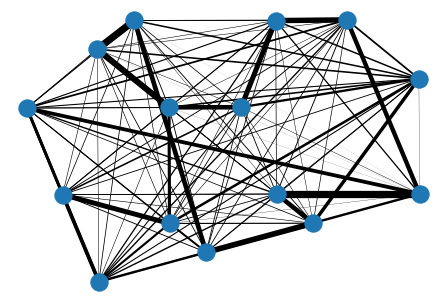

In [6]:
#パラメータ
REPEAT_NUM = 10000 # 繰り返し数
ANT_NUM = 100      # アリの数
PHERO_Q = 10       # 1回の巡回で分泌するフェロモン
EVA_R = 0.05       # フェロモンの蒸発率
PHERO_R = 0.95     # フェロモンに基づいて経路を選択する確率
PHERO_L = 1        # フェロモンを考慮する度合い
HEU_L = 1          # ヒューリスティック情報を考慮する度合い

# TSPのサンプル問題
places = [(-0.0000000400893815,    0.0000000358808126), 
          (-28.8732862244731230,  -0.0000008724121069), 
          (-79.2915791686897506,  21.4033307581457670), 
          (-14.6577381710829471,  43.3895496964974043), 
          (-64.7472605264735108, -21.8981713360336698), 
          (-29.0584693142401171,  43.2167287683090606), 
          (-72.0785319657452987,  -0.1815834632498404), 
          (-36.0366489745023770,  21.6135482886620949), 
          (-50.4808382862985496,  -7.3744722432402208), 
          (-50.5859026832315024,  21.5881966132975371), 
          (-0.1358203773809326,   28.7292896751977480), 
          (-65.0865638413727368,  36.0624693073746769), 
          (-21.4983260706612533,  -7.3194159498090388), 
          (-57.5687244704708050,  43.2505562436354225), 
          (-43.0700258454450875, -14.5548396888330487), 
         ]

# 座標からフィールドのcsvファイルを作成
create_dist_matrix(places, 'field.csv')


field = Field('field.csv') # フィールドのファイル読み込み
colony = Colony(field)
ant = [Ant(field) for i in range(ANT_NUM)]

#print('最初の各枝のフェロモン')
#colony.printPheromone(field)
#print()

for i in range(REPEAT_NUM):
    colony.selectRoute(field, ant)
    colony.renewPheromone(field, ant)
#    print(str(i)+'ステップ目の各ノード間のフェロモン')
#    colony.printPheromone(field)
#    print()

print('最終的な各枝のフェロモン')
colony.printPheromone(field)

# グラフの描画
G = nx.Graph()
pos = {}

for i in range(len(places)):
    G.add_node(i)
    pos[i] = (places[i][0], places[i][1])
    
edges=[]   
for i in range(len(places)):
    for j in range(len(places)):
        if i>=j:continue
        else:
            G.add_edge(i,j)
            edges.append(field.pheromone[i][j]*0.3)
nx.draw(G, pos,width=edges)